В этой задаче вам предстоит по данным из магазинов предсказать выручку.

# Задание:

* Выберите несколько магазинов для анализа (нужно строить отдельно по каждому, т.к. они находятся в разных регионах)
* Постройте графики (time plot, seasonality plot, series decomposition). Что вы можете по ним сказать?
* Проведите анализ данных, посчитайте количественные характеристики датасета
* Постройте наивные предсказания, по последнему, среднему значению на последние 4 недели данных
* Проверьте точность метриками MAPE, RMSE
* Сделайте правильную кросс-валидацию
* Используйте модель SARIMAX

Опционально:

* Используйте библиотеку Prophet для предсказания (https://facebook.github.io/prophet/)
* Используйте дополнительные предикторы для предсказания
А можно ли использовать тут XGBoost?

## Загрузка всего необходимого

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import math
import sklearn.model_selection as ms

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
from datetime import datetime as dt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Lesson_13/train.csv")
df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


# Анализ данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [4]:
df.describe(include = 'all')

,Store,Dept,Date,Weekly_Sales,IsHoliday
count,421570.000000,421570.000000,421570,421570.000000,421570
unique,NaN,NaN,143,NaN,2
top,NaN,NaN,2011-12-23,NaN,False
freq,NaN,NaN,3027,NaN,391909
mean,22.200546,44.260317,NaN,15981.258123,NaN
std,12.785297,30.492054,NaN,22711.183519,NaN
min,1.000000,1.000000,NaN,-4988.940000,NaN
25%,11.000000,18.000000,NaN,2079.650000,NaN
50%,22.000000,37.000000,NaN,7612.030000,NaN
75%,33.000000,74.000000,NaN,20205.852500,NaN


In [5]:
s = df.isna().sum()
nan = pd.DataFrame(data = s[s != 0].sort_values(ascending=False), columns=['Total NaN count'])
nan['Percent'] = df.isna().mean() * 100.0

nan.T

,Store,Dept,Date,Weekly_Sales,IsHoliday
Total NaN count,NaN,NaN,NaN,NaN,NaN
Percent,0,0,0,0,0


# Работа с датасетом

Пусть у нас нашим индексом будет дата. А isHoliday преобразуем в int. Тогда саму дату мы удаляем из значений. И также отсортируем индексы и магазины

In [6]:
df_index = df
df_index['Date'] = pd.to_datetime(df_index['Date'], format='%Y-%m-%d')
df_index.index = df_index['Date'].values
df_index.drop(columns = ['Date'], inplace=True)
df_index['IsHoliday'] = LabelEncoder().fit_transform(df['IsHoliday'])
df_index.info()
df_index.sort_index(inplace=True)
df_index.sort_values(['Store', 'Dept'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 16.1 MB


In [7]:
df_index

,Store,Dept,Weekly_Sales,IsHoliday
2010-02-05,1,1,24924.50,0
2010-02-12,1,1,46039.49,1
2010-02-19,1,1,41595.55,0
2010-02-26,1,1,19403.54,0
2010-03-05,1,1,21827.90,0
...,...,...,...,...
2012-09-28,45,98,508.37,0
2012-10-05,45,98,628.10,0
2012-10-12,45,98,1061.02,0
2012-10-19,45,98,760.01,0


In [8]:
df_index.groupby([df_index.index, df_index.Store, df_index.Dept]).aggregate(np.sum)

Weekly_Sales  IsHoliday
           Store Dept                         
2010-02-05 1     1         24924.50          0
                 2         50605.27          0
                 3         13740.12          0
                 4         39954.04          0
                 5         32229.38          0
...                             ...        ...
2012-10-26 45    93         2487.80          0
                 94         5203.31          0
                 95        56017.47          0
                 97         6817.48          0
                 98         1076.80          0

[421570 rows x 2 columns]

In [9]:
df_time = df_index.loc[(df_index["Store"] == 5) & (df_index["Dept"] == 1)].drop(['Dept', 'IsHoliday', 'Store'], axis=1)

# Графики

****time plot****

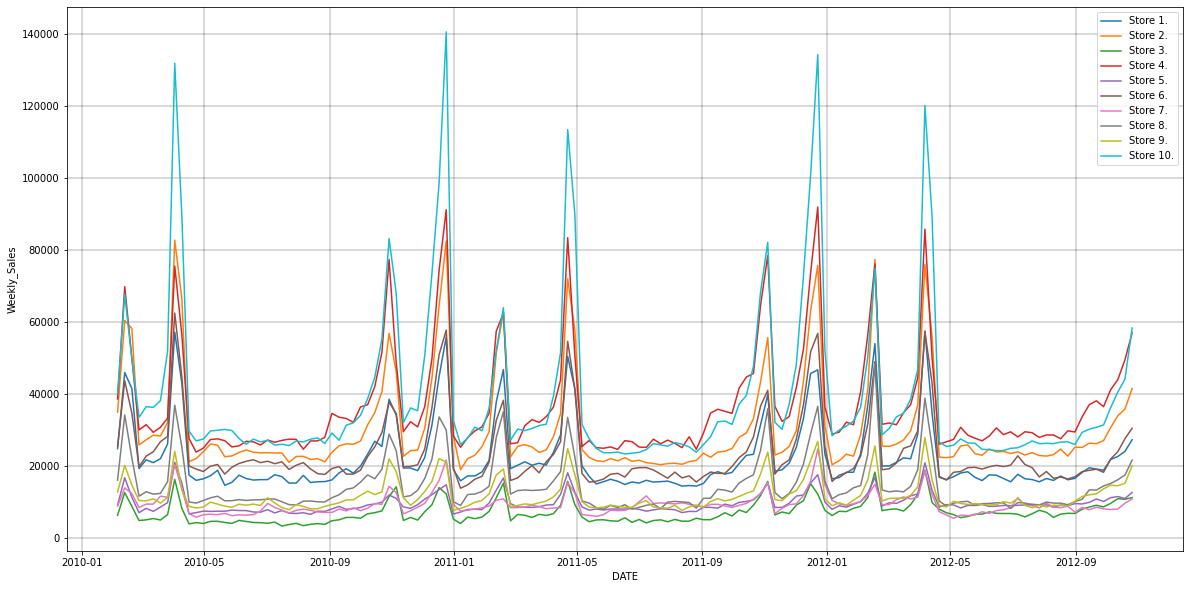

In [10]:
plt.figure(figsize=(20,10))
for i in range(1,11):
  df_time = df_index.loc[(df_index["Store"] == i) & (df_index["Dept"] == 1)].drop(['Dept', 'IsHoliday', 'Store'], axis=1)
  plt.plot(df_time.index, df_time["Weekly_Sales"], label="Store {}.".format(i))

plt.ylabel('Weekly_Sales')
plt.xlabel('DATE')
plt.legend()
plt.grid(color='black', linewidth=0.3)
plt.show()

Можно увидеть закономерность во всех 10 магазинов. Например, что в декабре всегда выручка больше. Так же идет резкий подъем всеъ магазинов по тем дням, что ближе к каким-то либо праздникам, как хелоуин. Выберу теперь 1 магазин для анализа мне нравится 4. 

In [11]:
df_time = df_index.loc[(df_index["Store"] == 4) & (df_index["Dept"] == 5)].drop(['Dept', 'IsHoliday', 'Store'], axis=1)
df_time.index.freq = df_time.index.inferred_freq

In [12]:
df_time

,Weekly_Sales
2010-02-05,48602.55
2010-02-12,48016.95
2010-02-19,45376.60
2010-02-26,37590.77
2010-03-05,40169.06
...,...
2012-09-28,49255.40
2012-10-05,44162.22
2012-10-12,39036.40
2012-10-19,41777.74


In [13]:
unique_keys = np.unique(df_time.index, return_counts=True)[0]
print("Dataset have {} unique dates.\nMin - {:%Y-%m-%d}\nMax - {:%Y-%m-%d}".format(len(unique_keys), df_time.index.min(), df_time.index.max()))
print("Period is {}.".format(df_time.index.inferred_freq))

Dataset have 143 unique dates.
Min - 2010-02-05
Max - 2012-10-26
Period is W-FRI.


Видим что у нас 143 уникальных дат. Отсчет идет с 5 февраля 2010 по 26 октября 2012 годов. Каждую неделю в пятницу

***series decomposition***


In [14]:
def get_decompositions(in_df: pd.DataFrame, model='additive'):

    work_col = in_df.columns.values[0]

    model_selector = {
        'additive': 0,
        'multiplicative': 1
    }

    result = [
        seasonal_decompose(in_df[work_col], model='additive'),
        seasonal_decompose(in_df[work_col], model='multiplicative')
    ]
    
    _, ax = plt.subplots(4, 2, figsize=(21, 14))
    axs = ax.flatten()

    y_labels =['Trend', 'Seasonal', 'Observed', 'Residual'] 

    for result_idx in range(2):
        result[result_idx].trend.plot(ax=axs[0 + result_idx])
        result[result_idx].seasonal.plot(ax=axs[2 + result_idx])
        result[result_idx].observed.plot(ax=axs[4 + result_idx])
        result[result_idx].resid.plot(ax=axs[6 + result_idx])

    for axis_idx in range(8)[::2]:
        axs[axis_idx].set_ylabel(y_labels[axis_idx // 2]) 
        axs[axis_idx + 1].set_ylabel(y_labels[axis_idx // 2])
        axs[axis_idx].grid()
        axs[axis_idx+1].grid()

    axs[0].set_title("Additive")
    axs[1].set_title("Multiplicative")
    plt.show()

    return result[model_selector[model]]

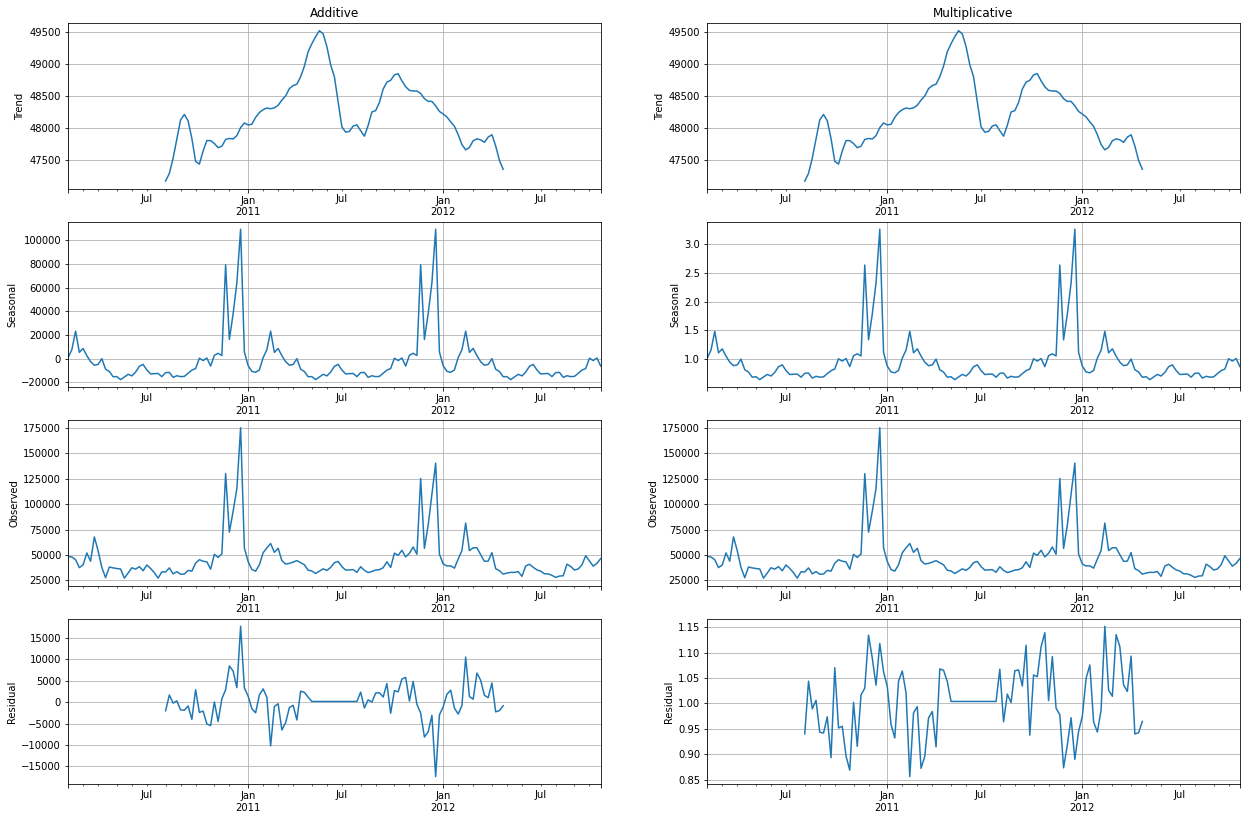

In [15]:
get_decompositions(df_time);

По таблице выше можно увидеть сезонность в декабре (рождество), начала ноября (хеллоуин) и апрелье. То есть где больше всех праздников.
 
Тренд колибается от 38 500 до 43 500 и пик в октябре. Спад идет начиная с февраля до июня

Единственное отличие Multiplicative от Additive это только в Residual. Но по нему мало что могу сказать. 

# Prediction

In [16]:
def split(df, n):
  train_df = df.iloc[:-n]
  test_df = df.iloc[-n:]
  return train_df, test_df

In [17]:
train, test = split(df_time,4)
test

,Weekly_Sales
2012-10-05,44162.22
2012-10-12,39036.40
2012-10-19,41777.74
2012-10-26,46483.60


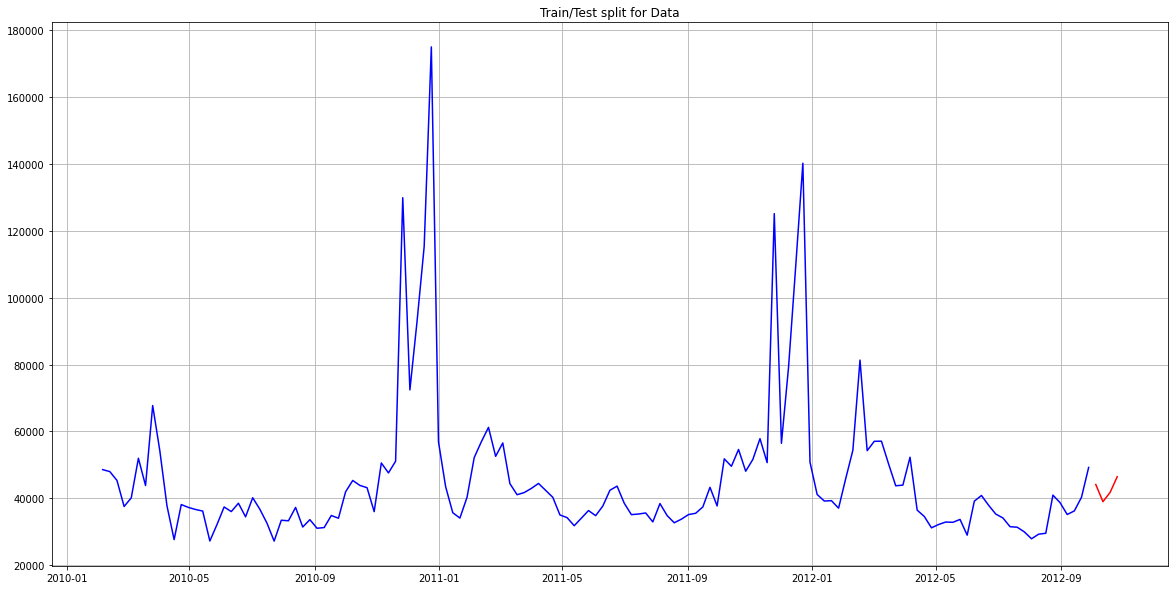

In [18]:
plt.figure(figsize=(20,10))

plt.title("Train/Test split for Data")
plt.plot(train.index, train['Weekly_Sales'], color='blue')
plt.plot(test.index, test['Weekly_Sales'], color='red')
plt.grid()
plt.show()

# Наивное предсказание

In [19]:
def native_prediction(t_df, n, **kwargs):
  last_value = t_df.iat[-1, 0]
  values = [last_value] * n
  
  start_date = t_df.index[-1] + pd.DateOffset(weeks=1)
  dates = pd.date_range(start = start_date, periods=n, freq='W-FRI')

  return pd.DataFrame({"value": values}, index= dates)

In [20]:
native_predictions = native_prediction(train,4)
native_predictions

,value
2012-10-05,49255.4
2012-10-12,49255.4
2012-10-19,49255.4
2012-10-26,49255.4


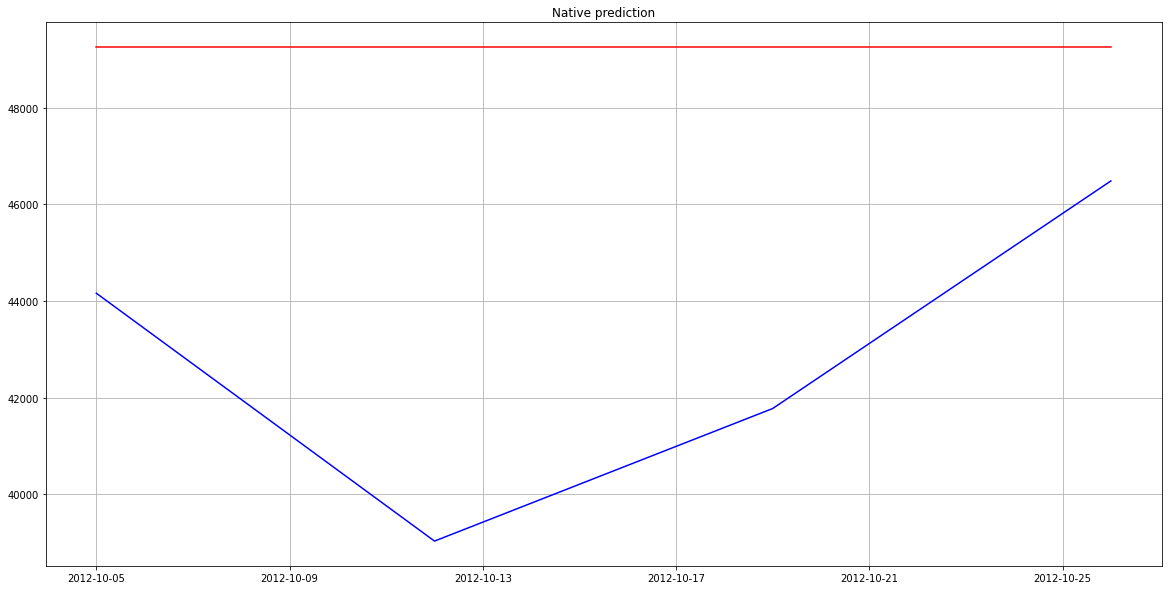

In [21]:
plt.figure(figsize=(20,10))

plt.title("Native prediction")
plt.plot(test.index, test['Weekly_Sales'], color='b')
plt.plot(native_predictions.index, native_predictions['value'], color='r')
plt.grid()
plt.show()

# Среднее предсказание

In [22]:
def average_prediction(t_df, n, **kwargs):
    mean_value = t_df['Weekly_Sales'].mean()
    values = [mean_value] * n
  
    start_date = t_df.index[-1] + pd.DateOffset(weeks=1)
    dates = pd.date_range(start = start_date, periods=n, freq='W-FRI')

    return pd.DataFrame({"value": values}, index= dates)

In [23]:
average_predictions = average_prediction(train,4)
average_predictions

,value
2012-10-05,45749.080647
2012-10-12,45749.080647
2012-10-19,45749.080647
2012-10-26,45749.080647


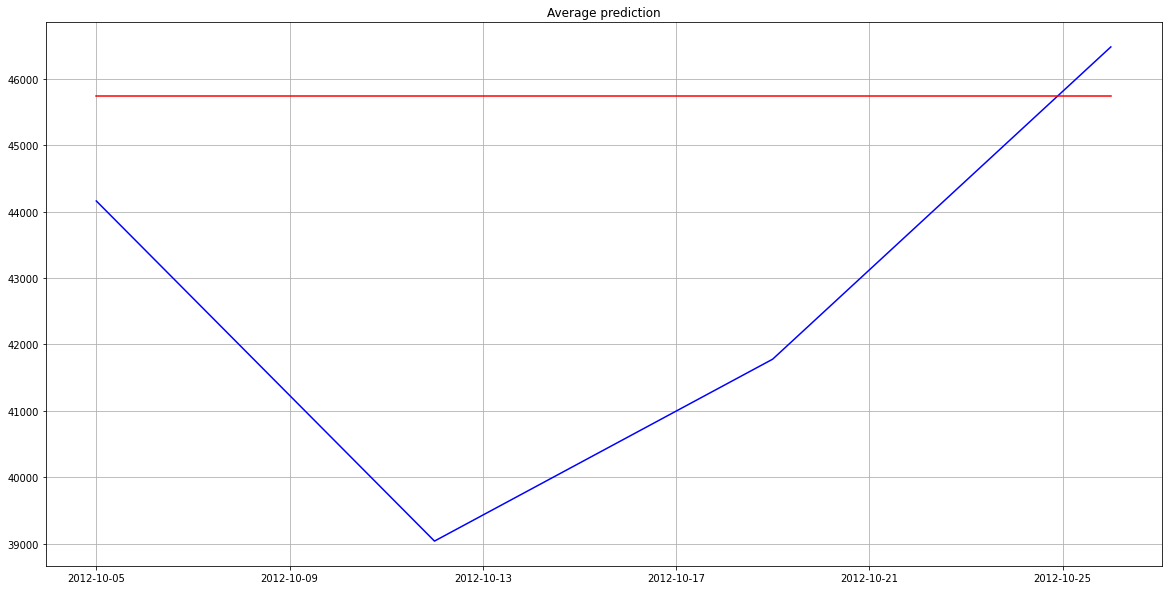

In [24]:
plt.figure(figsize=(20,10))

plt.title("Average prediction")
plt.plot(test.index, test['Weekly_Sales'], color='b')
plt.plot(average_predictions.index, average_predictions['value'], color='r')
plt.grid()
plt.show()

# Сравниваем 2 предсказания по ментрикам

In [25]:
def errors(test, prediction):
    errors = dict()
    errors['MAE'] = metrics.mean_absolute_error(test, prediction)
    errors['MSE'] = metrics.mean_squared_error(test, prediction)
    errors['RMSE'] = math.sqrt(metrics.mean_squared_error(test, prediction))
    errors['R2'] = metrics.r2_score(test, prediction)
    errors['MAPE'] = metrics.mean_absolute_percentage_error(test, prediction)
    return errors

In [26]:
print("Native:")
errors(test['Weekly_Sales'], native_predictions['value'])

Native:


{'MAE': 6390.410000000002,
 'MAPE': 0.15393163581644986,
 'MSE': 48491679.45700002,
 'R2': -5.335187971126787,
 'RMSE': 6963.5967327954895}

In [27]:
print("Average:")
errors(test['Weekly_Sales'], average_predictions['value'])

Average:


{'MAE': 3251.350323741006,
 'MAPE': 0.0796881297187784,
 'MSE': 15972318.351793215,
 'R2': -1.0867010634889667,
 'RMSE': 3996.538296049872}

# Теперь при N=10

В задачах было посмотреть последние 4. Но ради интереса сделаю больше и сравню ошибки

In [28]:
train_10, test_10 = split(df_time,10)
test_10

,Weekly_Sales
2012-08-24,40981.28
2012-08-31,38738.20
2012-09-07,35199.92
2012-09-14,36270.10
2012-09-21,40347.24
2012-09-28,49255.40
2012-10-05,44162.22
2012-10-12,39036.40
2012-10-19,41777.74
2012-10-26,46483.60


In [29]:
native_predictions = native_prediction(train_10,10)
average_predictions = average_prediction(train_10,10)

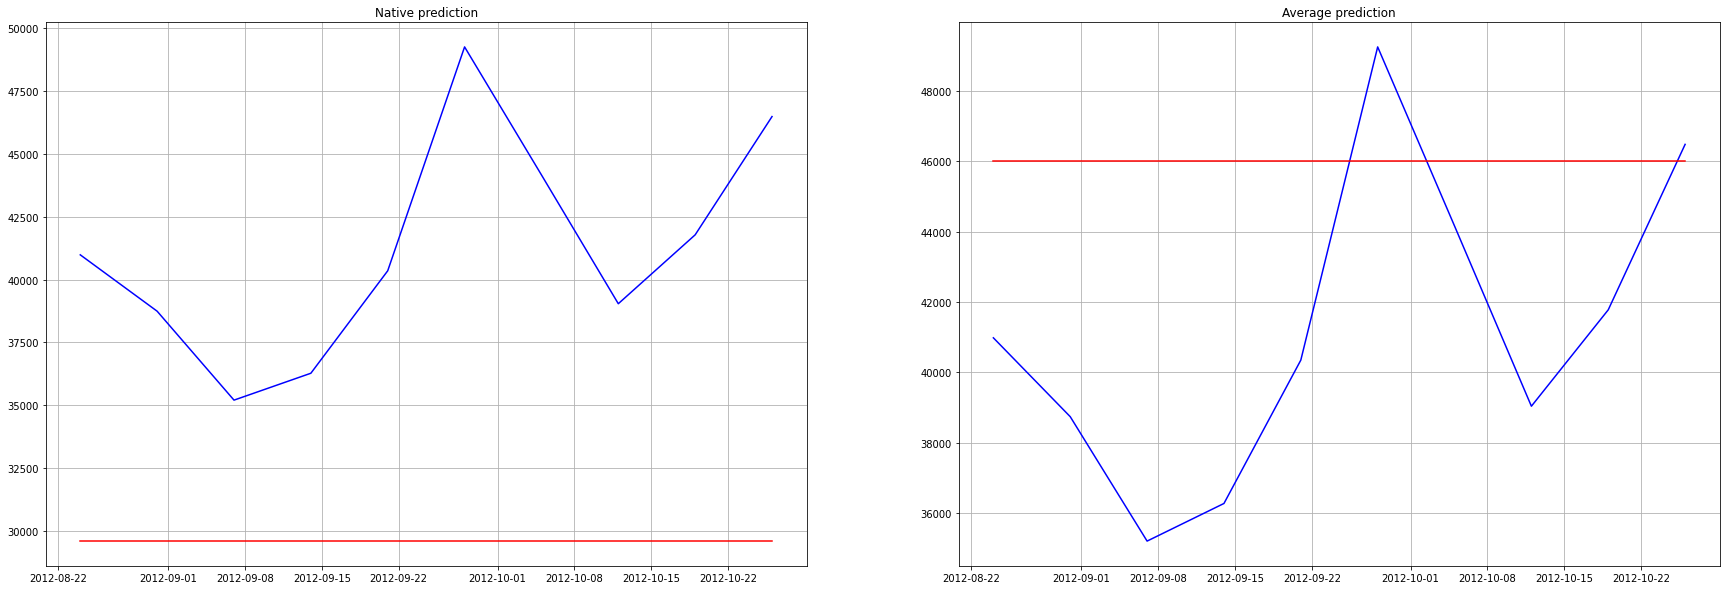

In [30]:
_, ax = plt.subplots(1, 2, figsize=(30, 10))
axs = ax.flatten()

axs[0].plot(test_10.index, test_10['Weekly_Sales'], color='b')
axs[0].plot(native_predictions.index, native_predictions['value'], color='r')
axs[0].grid()

axs[1].plot(test_10.index, test_10['Weekly_Sales'], color='b')
axs[1].plot(average_predictions.index, average_predictions['value'], color='r')
axs[1].grid()

axs[0].set_title("Native prediction")
axs[1].set_title("Average prediction")
plt.show()

In [31]:
print("Native:")
errors(test_10['Weekly_Sales'], native_predictions['value'])

Native:


{'MAE': 11634.41,
 'MAPE': 0.2750460578197625,
 'MSE': 152732457.02684,
 'R2': -7.7913889413407915,
 'RMSE': 12358.49736120213}

In [32]:
print("Average:")
errors(test_10['Weekly_Sales'], average_predictions['value'])

Average:


{'MAE': 5524.079037593985,
 'MAPE': 0.14230711542672972,
 'MSE': 40195286.1545317,
 'R2': -1.3136692820366256,
 'RMSE': 6339.975248731788}

Результат стал хуже... Это объясняется тем что у нас прямая линия и большой размах. Поэтому и имеем плохой результат метрик. Нужно просто менять метод предсказания. Писать не Native и average predictions а более сложные методы.

Из всего проделанного выше можно сделать вывод: Averege работает луше чем Native.

# Кросс валидация

In [33]:
def make_cv_splits(df_splits, n):
    cv_splits = ms.TimeSeriesSplit(n_splits=n)
    data = cv_splits.split(df_splits)

    data_df_cv_splits = []
    for train_indices, test_indices in data:
      train, test = df_splits.iloc[train_indices], df_splits.iloc[test_indices]
      data_df_cv_splits.append((train, test))

      plt.figure(figsize=(12,5))
      plt.plot(train.index, train['Weekly_Sales'], color = 'b', label='Train')
      plt.plot(test.index, test['Weekly_Sales'], color = 'r', label='Test')
      plt.legend(loc= 'best')
      plt.grid()
    
    data_df_cv_splits.pop(0)
    return data_df_cv_splits

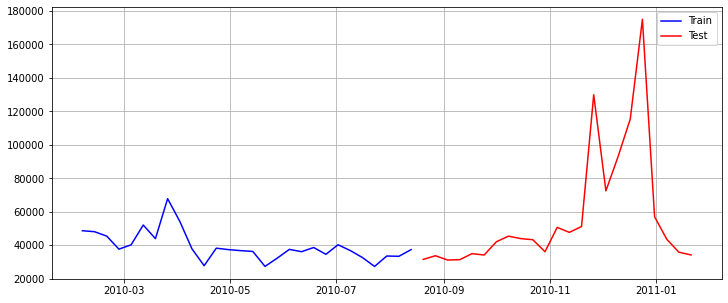

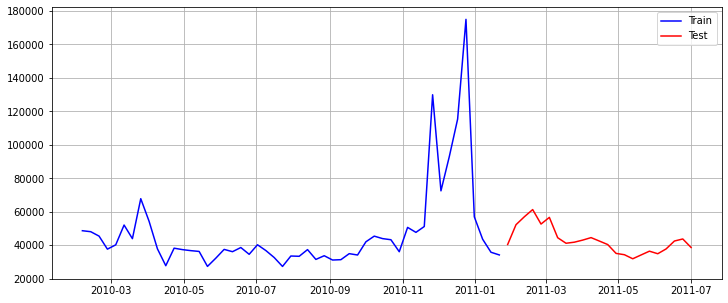

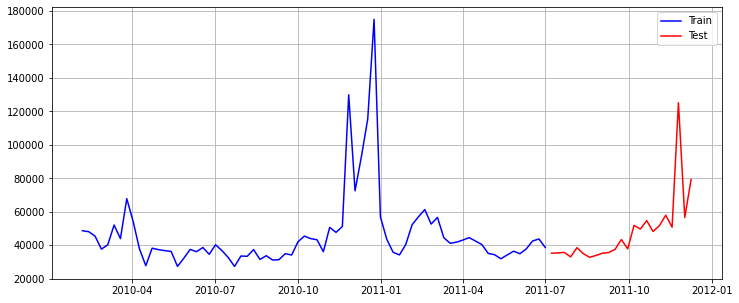

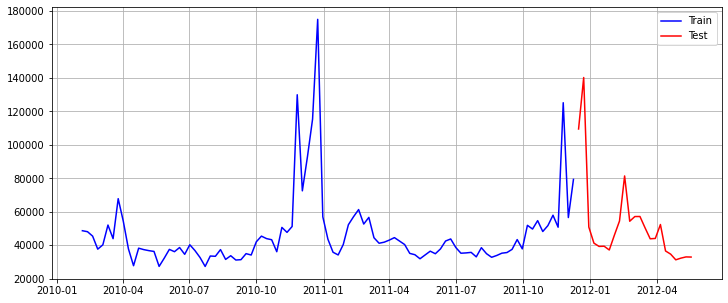

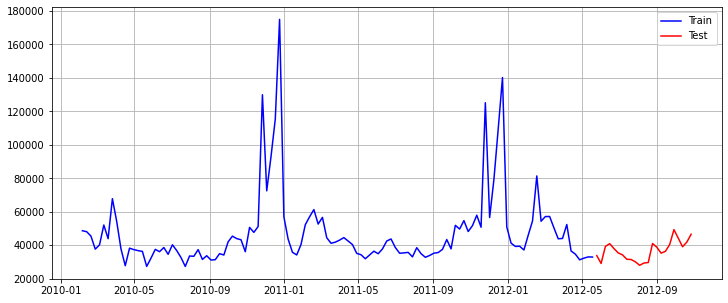

In [34]:
cv_df_time = make_cv_splits(df_time, 5)

# Предсказание на кросс валидации

Теперь реализуем предсказание на основе кросс валидации. То есть по частям. Сравним 2 метода

In [35]:
def cv_prediction(cv_splits, model, **kwargs):
  predictions = []
  for train_df, test_df in cv_splits:
      predicted_df = model(train_df, len(test_df))
      predictions.append(predicted_df)
  return pd.concat(predictions)

In [36]:
test_data = pd.concat([t for (_,t) in cv_df_time])

In [37]:
average_predictions = cv_prediction(cv_df_time, average_prediction)
errors(test_data, average_predictions)

{'MAE': 11833.624560970731,
 'MAPE': 0.25819276442241895,
 'MSE': 327964785.3615437,
 'R2': -0.03185683530991379,
 'RMSE': 18109.7980486129}

In [38]:
native_predictions = cv_prediction(cv_df_time, native_prediction)
errors(test_data, native_predictions)

{'MAE': 15528.077717391307,
 'MAPE': 0.3359239112223273,
 'MSE': 512666138.441764,
 'R2': -0.6129721323583959,
 'RMSE': 22642.131932346034}

Удивительно, но почему-то результат стал хуже, кроме детерменации. То есть долю вариации результативного признака под влиянием времени. Что довольно интересный результат. Посмотрим график

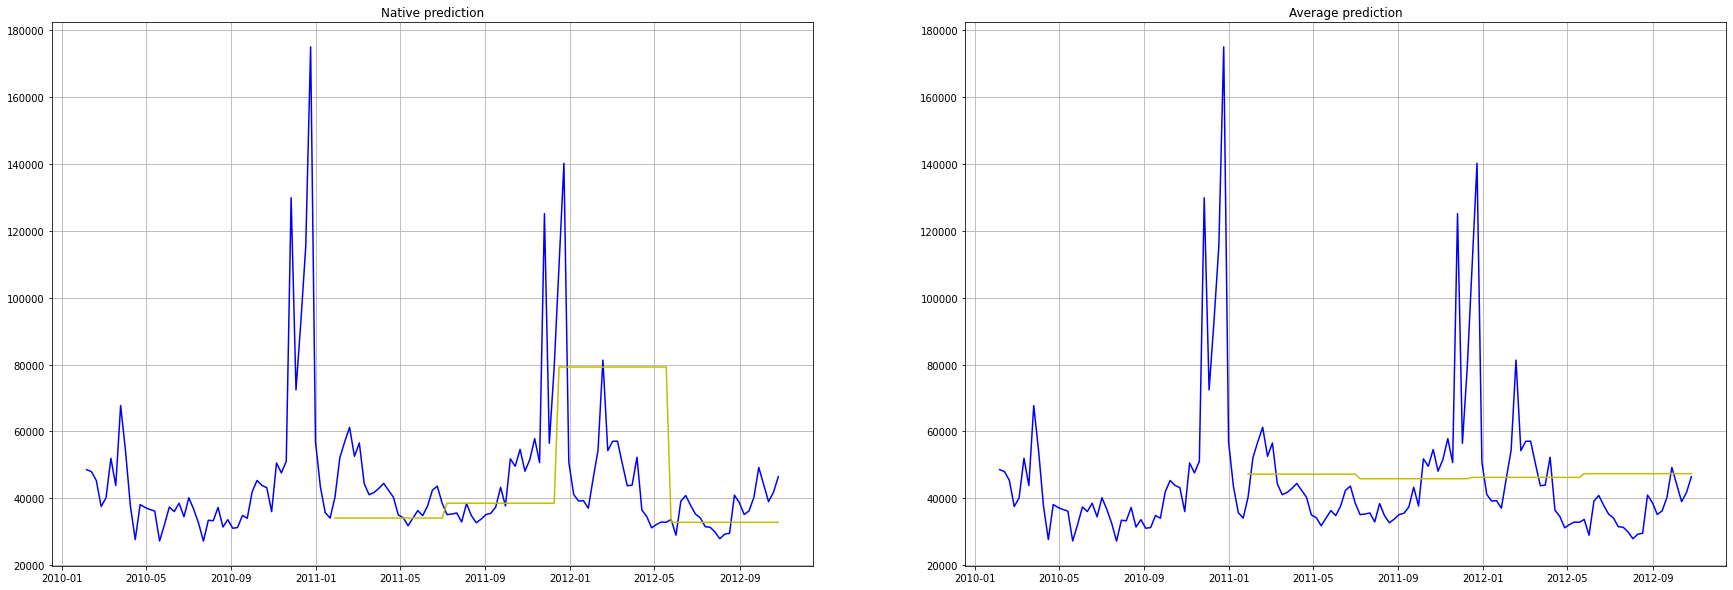

In [39]:
_, ax = plt.subplots(1, 2, figsize=(30, 10))
axs = ax.flatten()

axs[0].plot(df_time.index, df_time['Weekly_Sales'], color='b')
axs[0].plot(native_predictions.index, native_predictions['value'], color='y')
axs[0].grid()

axs[1].plot(df_time.index, df_time['Weekly_Sales'], color='b')
axs[1].plot(average_predictions.index, average_predictions['value'], color='y')
axs[1].grid()

axs[0].set_title("Native prediction")
axs[1].set_title("Average prediction")
plt.show()

Теперь все стало ясно. В обоих случаях виновата сезонность и большой размах графика. (Инными словами "нестабильность"), что особо заметно в период с декабря 2011 по июнь 2012. Ситуацию может решить разбиение графика на еще более мелкие части. Чем больше частей разбиение - тем лучше будет результат. Но это будет крайне плохим решением как минимум из-за времени выполнения

# SARIMAX

In [40]:
import statsmodels.tsa.statespace.sarimax as statsmodels_sarimax

def sarimax_prediction(t_df, n):
  sarima_model = statsmodels_sarimax.SARIMAX(t_df, order = (1,1,1), seasonal_order = (1,1,1,12))
  sarima_model_fit = sarima_model.fit(disp= False)
  values = sarima_model_fit.forecast(n)

  start_date = t_df.index[-1] + pd.DateOffset(weeks=1)
  dates = pd.date_range(start = start_date, periods=n, freq='W-FRI')

  return pd.DataFrame({"value": values}, index= dates)

In [41]:
sarima_predictions = cv_prediction(cv_df_time, sarimax_prediction)
errors(test_data, sarima_predictions)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


{'MAE': 26988.310643943147,
 'MAPE': 0.6492175769303032,
 'MSE': 1570325026.4214747,
 'R2': -3.940623763569519,
 'RMSE': 39627.32676350342}

Еще хуже... Выбрал я, конечно, хороший магазин. Посмотрим на график

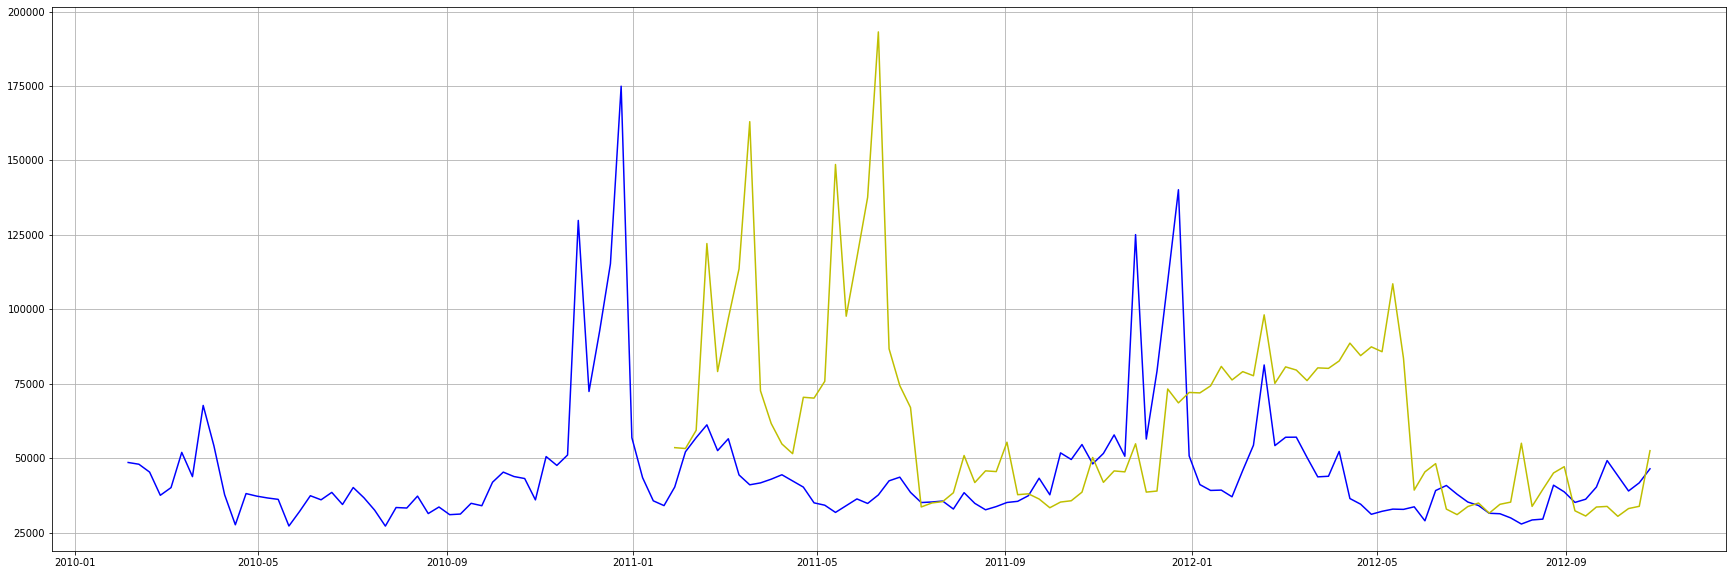

In [42]:
plt.figure(figsize=(30,10))

plt.plot(df_time.index, df_time['Weekly_Sales'], color='b')
plt.plot(sarima_predictions.index, sarima_predictions['value'], color='y')
plt.grid()

Тут можно увидеть что метрики настолько плохие из-за того результата что у нас в пережудке между яварем 2011 и июлем 2011. В остольном ситуация лучше. и опять же виноват размах между 25000 и 175000. Неудевительно, что метрики такие плохие с такой разницей.

# Prophet

Что же. Выпускаем тяжелую артелерию. Библиотеку что создана для предсказывания по времени. В качестве страны я выбрал США. Так как продажи резко заканчиваются после рождества, а не нового года. Конечно так себе замечание, но по крайней мере ясно, что это не Украина и не Россия.

In [44]:
!pip install prophet
from prophet import Prophet
train, test = split(df_time,4)
m = Prophet(yearly_seasonality= True)
m.add_country_holidays(country_name = 'USA')

     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 49 kB 4.6 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639978 sha256=553f64369462bf6e6f04efa888df1181964210b0ac26648c2ae329f6dc60eadb
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [45]:
m.fit(train.reset_index().rename({'index': 'ds', 'Weekly_Sales': 'y'}, axis = 1))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


задаю 4 недели (28 дней)

In [46]:
future = m.make_future_dataframe(periods= 28)
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-05,45702.770116,39426.997683,65027.739712,45702.770116,45702.770116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6627.429670,6627.429670,6627.429670,0.0,0.0,0.0,6627.429670,6627.429670,6627.429670,0.0,0.0,0.0,52330.199786
1,2010-02-12,45725.035551,43623.223622,69121.494420,45725.035551,45725.035551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10658.554121,10658.554121,10658.554121,0.0,0.0,0.0,10658.554121,10658.554121,10658.554121,0.0,0.0,0.0,56383.589672
2,2010-02-19,45747.300986,41581.085195,66130.846681,45747.300986,45747.300986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8387.739124,8387.739124,8387.739124,0.0,0.0,0.0,8387.739124,8387.739124,8387.739124,0.0,0.0,0.0,54135.040110
3,2010-02-26,45769.566421,37531.920911,62838.588672,45769.566421,45769.566421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4481.512894,4481.512894,4481.512894,0.0,0.0,0.0,4481.512894,4481.512894,4481.512894,0.0,0.0,0.0,50251.079315
4,2010-03-05,45791.831856,36022.446842,61083.537266,45791.831856,45791.831856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2300.364489,2300.364489,2300.364489,0.0,0.0,0.0,2300.364489,2300.364489,2300.364489,0.0,0.0,0.0,48092.196345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2012-10-22,48830.732641,33722.336740,57870.050421,48830.714665,48830.750894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3334.453860,-3334.453860,-3334.453860,0.0,0.0,0.0,-3334.453860,-3334.453860,-3334.453860,0.0,0.0,0.0,45496.278781
163,2012-10-23,48833.871162,32010.519726,57408.579729,48833.851601,48833.891371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3826.249315,-3826.249315,-3826.249315,0.0,0.0,0.0,-3826.249315,-3826.249315,-3826.249315,0.0,0.0,0.0,45007.621847
164,2012-10-24,48837.009683,3170

In [47]:
future

,ds
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
...,...
162,2012-10-22
163,2012-10-23
164,2012-10-24
165,2012-10-25


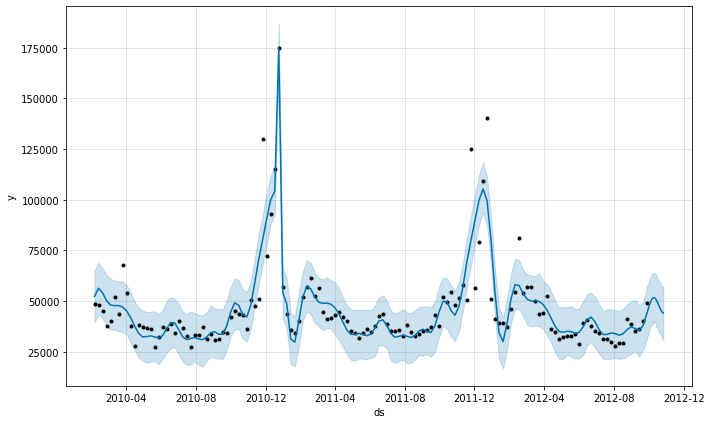

In [48]:
fig1 = m.plot(forecast)

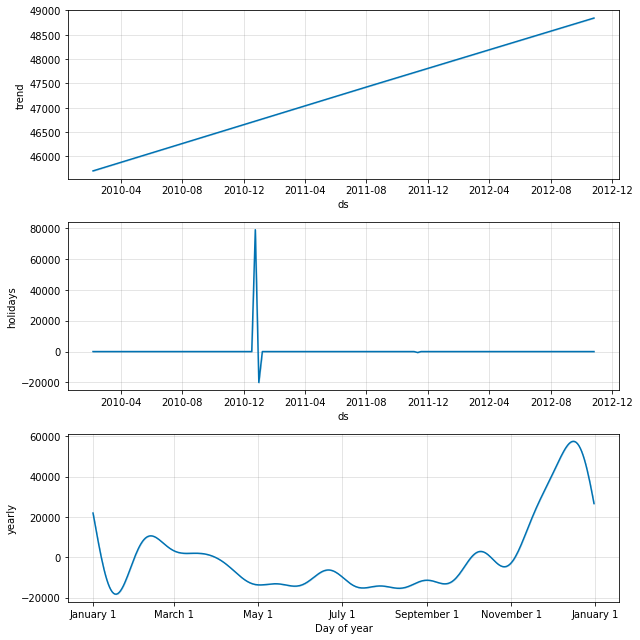

In [49]:
fig2 = m.plot_components(forecast)

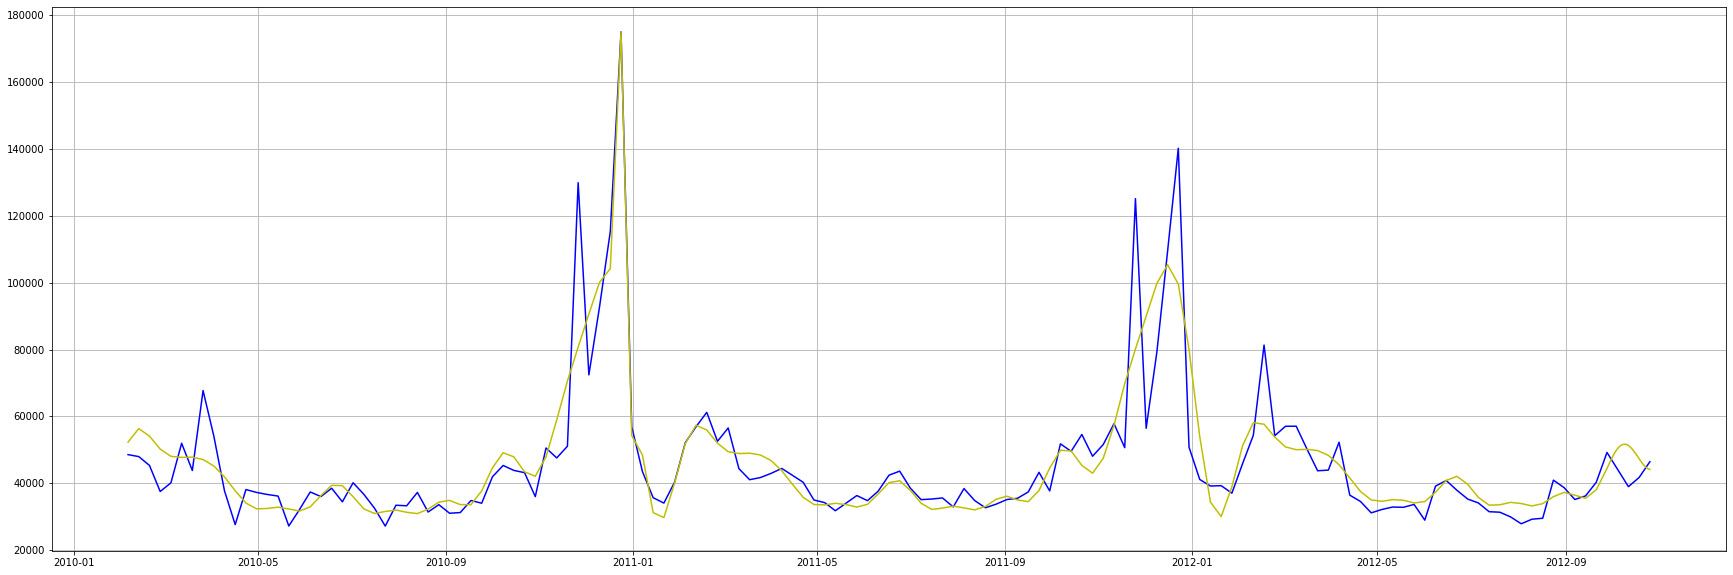

In [50]:
plt.figure(figsize=(30,10))

plt.plot(df_time.index, df_time['Weekly_Sales'], color='b')
plt.plot(forecast['ds'], forecast['yhat'], color='y')
plt.grid()

Видно что ситуация просто отличная. По сравнению с тем что было этот метод идеально работает. Показывает сезонность отлично определяет выручку, так еще и графики строит и выводит полностью информацию! Можно сделать результат еще лучше с помощью кросс валидации

In [59]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, period= f'{7} days', horizon=f'{4*7} days')

INFO:prophet:Making 82 forecasts with cutoffs between 2011-02-11 00:00:00 and 2012-08-31 00:00:00


  0%|          | 0/82 [00:00<?, ?it/s]

In [52]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-01-14,-116411.006644,-127221.418853,-106713.526137,35733.27,2011-01-07
1,2011-01-21,-301248.229778,-311759.597691,-290846.049957,34124.65,2011-01-07
2,2011-01-28,-444088.132750,-453986.489026,-433085.601840,40370.22,2011-01-07
3,2011-02-04,-512689.682274,-523425.046409,-502983.944045,52192.61,2011-01-07
4,2011-01-21,31779.556562,20412.247112,43048.856780,34124.65,2011-01-14
...,...,...,...,...,...,...
343,2012-09-21,36661.356999,23026.838922,49408.689914,40347.24,2012-08-24
344,2012-09-07,36368.992985,23691.402329,49524.348067,35199.92,2012-08-31
345,2012-09-14,34797.272461,20256.614748,47930.155177,36270.10,2012-08-31
346,2012-09-21,36641.066834,24085.227766,50223.773816,40347.24,2012-08-31


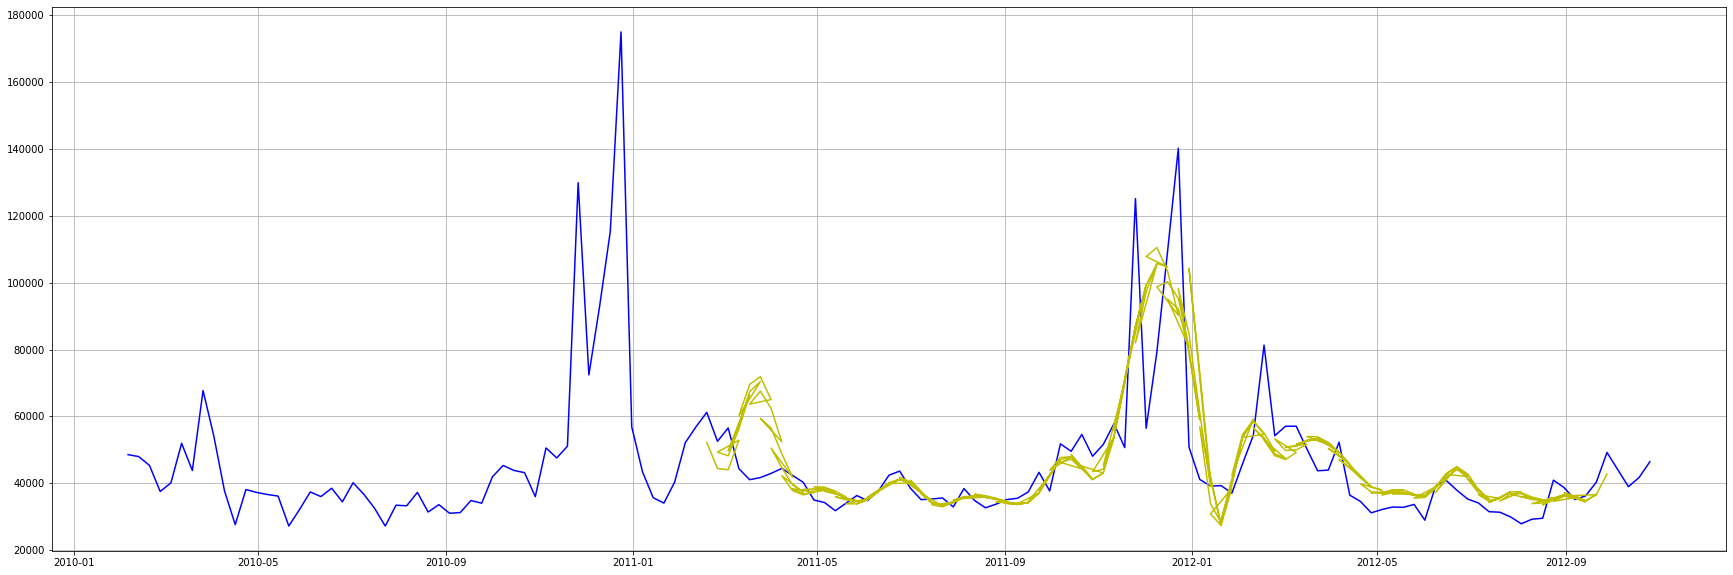

In [60]:
plt.figure(figsize=(30,10))

plt.plot(df_time.index, df_time['Weekly_Sales'], color='b')
plt.plot(df_cv['ds'], df_cv['yhat'], color='y')
plt.grid()

In [61]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv, rolling_window= 4*7)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,1.600422e+08,12650.780425,7876.734188,0.162101,0.117361,0.149598,0.841463


Ситуация, конечно, не самая лучшая. Но это лучшие результаты из всех методов, что были ранее. Можно применить метод XGBoost. Но эта работа меня выматала достаточно. Так что пропущу этот пункт

# Выводы

С этой темой надо разбиратся очень долго, чтобы мастерски предсказывать с минимальными ошибками. В моем случае эта работа просто для ознакомления с методами и самой темой Time Series. Для улучшения результатов отилчно бы подошло разбиение на большее количество частей. А так же я выбрал магазин с большим размахом, из-за чего почти все методы были с большой средней ошибкой. Из-за этого размаха и большой "нестабильности" графика мы и получаем такой результат. Если же оценивать по графикам, то лучше всего справился prophet (даже на последних метриках и графике видно). Хуже всех - SARIMAX.